# Importing Modules

In [1]:
#import sys
#sys.path.append('/home/a39083/UNET-Sampling/crimac_unet/')

from data.echogram import DataReaderZarr, get_data_readers
import numpy as np
from tqdm import tqdm
import dask
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage.morphology import binary_closing
from scipy import stats as st
from pandas.plotting import scatter_matrix
import xarray as xr
import seaborn as sns
from imblearn.under_sampling import NearMiss

dask.config.set(**{'array.slicing.split_large_chunks': False})

#  Path to surveys
survey_path = '/data/'

#  Get list of relevant surveys
surveys = ['2019/S2019847/ACOUSTIC/GRIDDED/S2019847_sv.zarr']
readers = [DataReaderZarr(survey_path + zarr_file) for zarr_file in surveys]

# Or alternatively ...
# readers = get_data_readers()

patch_size = (256, 256)  # x, y
survey = readers[0]

# Functions

In [2]:
def xr_db_with_limits(xarr, limit_low=-75, limit_high=0): # Function to be applied to xarray dataarray
    data = db(xarr)
    result = data.where((data<limit_high) | (data.isnull()), limit_high)
    result = result.where((result>limit_low) | (result.isnull()), limit_low)
    return result

def db(data, eps=1e-10):
    return 10 * np.log10(data + eps)

def db_with_limits(data, limit_low=-75, limit_high=0):
    data = db(data)
    data[data>limit_high] = limit_high
    data[data<limit_low] = limit_low
    return data

class P_refine_label_boundary():
    def __init__(self,
                 frequencies=[18, 38, 120, 200],
                 threshold_freq=200,
                 threshold_val=[1e-7, 1e-4],
                 ignore_val=-100,
                 ignore_zero_inside_bbox=True
                 ):
        self.frequencies = frequencies
        self.threshold_freq = threshold_freq
        self.threshold_val = threshold_val
        self.ignore_val = ignore_val
        self.ignore_zero_inside_bbox=ignore_zero_inside_bbox

    def __call__(self, data, labels, echogram):
        '''
        Refine existing labels based on thresholding with respect to pixel values in image.
        :param data: (numpy.array) Image (C, H, W)
        :param labels: (numpy.array) Labels corresponding to image (H, W)
        :param echogram: (Echogram object) Echogram
        :param threshold_freq: (int) Image frequency channel that is used for thresholding
        :param threshold_val: (float) Threshold value that is applied to image for assigning new labels
        :param ignore_val: (int) Ignore value (specific label value) instructs loss function not to compute gradients for these pixels
        :param ignore_zero_inside_bbox: (bool) labels==1 that is relabeled to 0 are set to ignore_value if True, 0 if False
        :return: data, new_labels, echogram
        '''

        closing = np.array([
            [0, 0, 1, 1, 1, 0, 0],
            [0, 1, 1, 1, 1, 1, 0],
            [1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1],
            [0, 1, 1, 1, 1, 1, 0],
            [0, 0, 1, 1, 1, 0, 0]
        ])

        if self.ignore_val == None:
            self.ignore_val = 0

        # Set new label for all pixels inside bounding box that are below threshold value
        if self.ignore_zero_inside_bbox:
            label_below_threshold = self.ignore_val
        else:
            label_below_threshold = 0

        # Get refined label masks
        freq_idx = self.frequencies.index(self.threshold_freq)

        # Relabel
        new_labels = labels.copy()

        mask_threshold = (labels != 0) & (labels != self.ignore_val) & (data[freq_idx, :, :] > self.threshold_val[0]) & (
                    data[freq_idx, :, :] < self.threshold_val[1])
        # Padding
        mask_threshold = np.pad(mask_threshold, ((3,3),(3,3)), 'constant')
        
        mask_threshold_closed = binary_closing(mask_threshold, structure=closing)
        
        # Remove Padding
        mask_threshold_closed = mask_threshold_closed[3:-3,3:-3]
        
        mask = (labels != 0) & (labels != self.ignore_val) & (mask_threshold_closed == 0)

        new_labels[mask] = label_below_threshold
        new_labels[labels == self.ignore_val] = self.ignore_val

        return data, new_labels, echogram

# Selecting the Acoustic Data Portion to Analyze

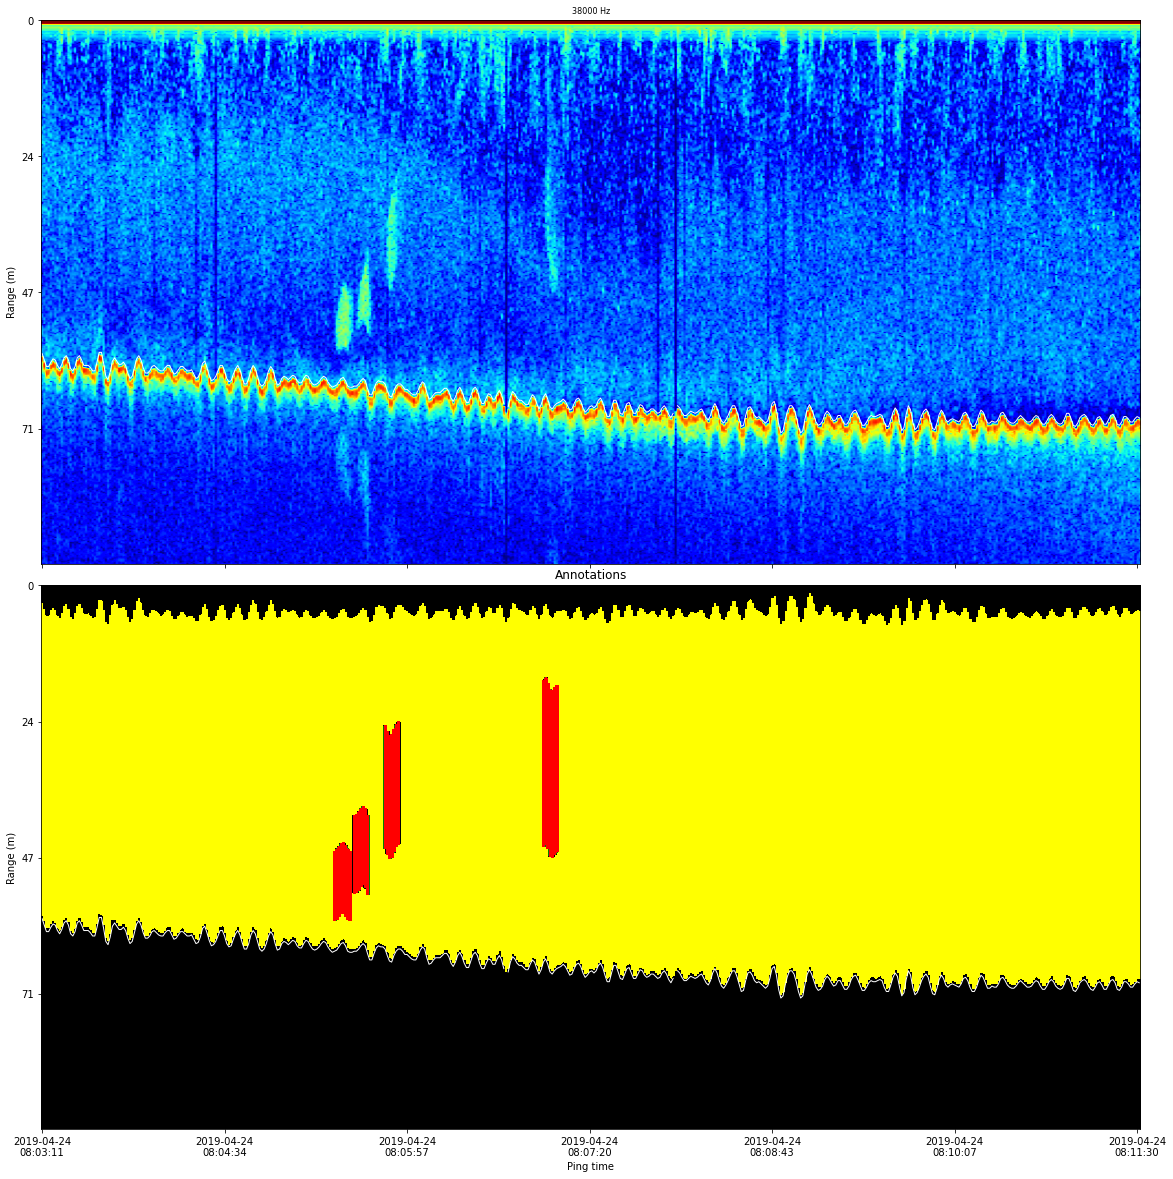

In [3]:
idx_ping = 46776
n_pings = 500
idx_range = 0
n_range = 500

# selected echogram: ping_time = (46776:47276), range = (0:500) (500*500 = 250000 pixels * 4 frequency + 1 depth channel)

survey.visualize(ping_idx=idx_ping, n_pings=n_pings, range_idx=idx_range, 
                 n_range=n_range, draw_seabed=True, show_labels=True, frequencies=[38000])

# Extracting Annotation and Sv Values for the corresponding crop

In [ ]:
class ClsNearmiss():
    def __init__(self, survey, idx_ping=46776, n_pings=500, idx_range=0, n_range = 500, frequencies=[18000, 38000, 120000, 200000]):
        self.org_sv = survey.get_data_slice(idx_ping=idx_ping, n_pings=n_pings, idx_range=idx_range, n_range=n_range,
                                   return_numpy=False, frequencies=self.frequencies)
        

In [4]:
# to get data slice
org_sv = survey.get_data_slice(idx_ping=idx_ping, n_pings=n_pings, idx_range=idx_range, n_range=n_range,
                                   return_numpy=False, frequencies=[18000, 38000, 120000, 200000])
data_Sv = xr_db_with_limits(org_sv)

# to get label slice
y_label = survey.get_label_slice(idx_ping=idx_ping, n_pings=n_pings, idx_range=idx_range, n_range=n_range,
                                 return_numpy=True)
# Update -1 Class
y_label[y_label==-1] = 0

# Annotation Modification
collection = P_refine_label_boundary(ignore_zero_inside_bbox=False, threshold_val=[1e-07, 1e-04],
                                       frequencies=[18, 38, 120, 200])(
    data=org_sv.values, labels=y_label,echogram=org_sv.values)

# Defining Sv data for 4 frequency channels and modified labels as numpy arrays
Sv_data, mod_labels = db_with_limits(collection[0]), collection[1]

# Creating Depth array

In [5]:
# Depth array creation from scratch
depth = np.expand_dims(np.array(np.arange(n_range)), axis=0)
depth = np.repeat(depth, [n_pings], axis=0)

# Concatenating with Sv Data
depth_tens=np.expand_dims(depth, axis=0)
input_data = np.append(Sv_data, depth_tens, axis=0)

# Creating Pandas Dataframe Containing Sv Data, Depth and Labels

In [6]:
# Creating flattened Numpy Array with frequency and depth
data_list = [input_data[i].flatten() for i in range(5)]
input_data_flat = np.asarray(data_list).T

# Converting into Pandas Dataframe
pd_all = pd.DataFrame(input_data_flat, columns=('18_Sv', '38_Sv', '120_Sv', '200_Sv', 'depth'))
pd_all['label'] = mod_labels.flatten()
# Change labels column to 'object' datatype
pd_all.label = pd_all.label.astype('object')

# Visualization of each input pair

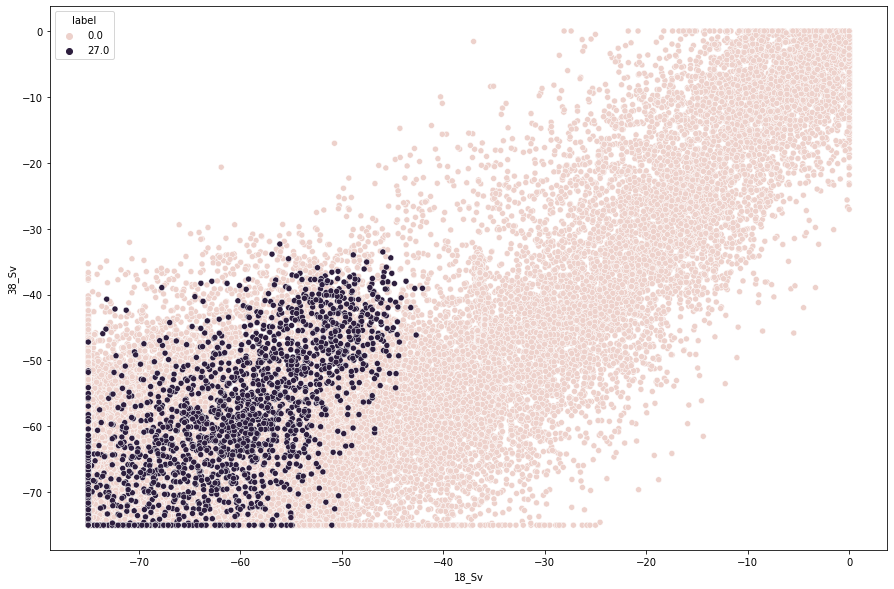

In [7]:
# Sandeel on top of Background
plt.figure(figsize=(15,10))
hue_order = ["27.0", "0.0"]
sns.scatterplot(data=pd_all.sort_values(by='label'), x="18_Sv", y="38_Sv", hue='label', hue_order=hue_order)
plt.show()

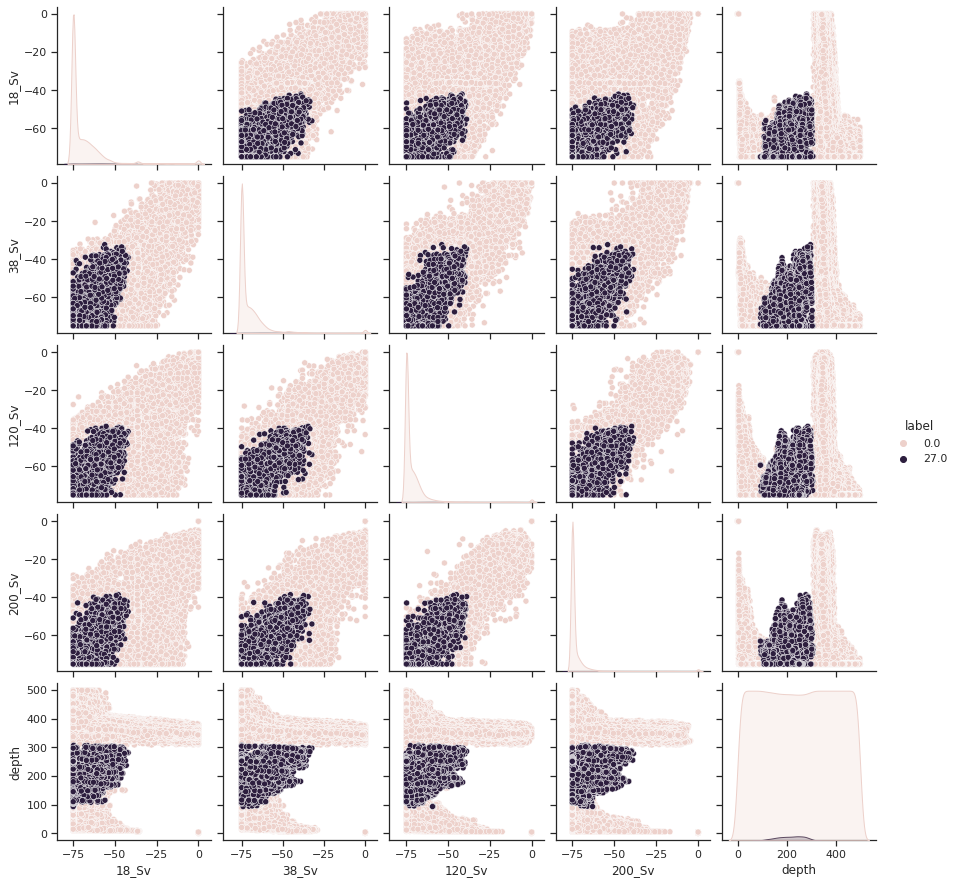

In [8]:
# Pair Plot of the Dataset
sns.set_theme(style="ticks")
sns.pairplot(data=pd_all.sort_values(by='label'), hue="label")
plt.show()

# Near Miss Algorithm

In [9]:
# Normalization of the Depth Column
pd_all.depth = (pd_all.depth-pd_all.depth.min())/pd_all.depth.std()

In [10]:
%%time
# 2000/0.025= 80000 samples of pixels, SD + Bg
nr = NearMiss(version=2, sampling_strategy=0.025) 
X_train, y_train = pd_all.iloc[:,0:5], pd_all.iloc[:,5]
X_near, Y_near= nr.fit_resample(X_train, y_train.ravel().astype('str')) 

CPU times: user 49.8 s, sys: 7.13 s, total: 57 s
Wall time: 56.9 s


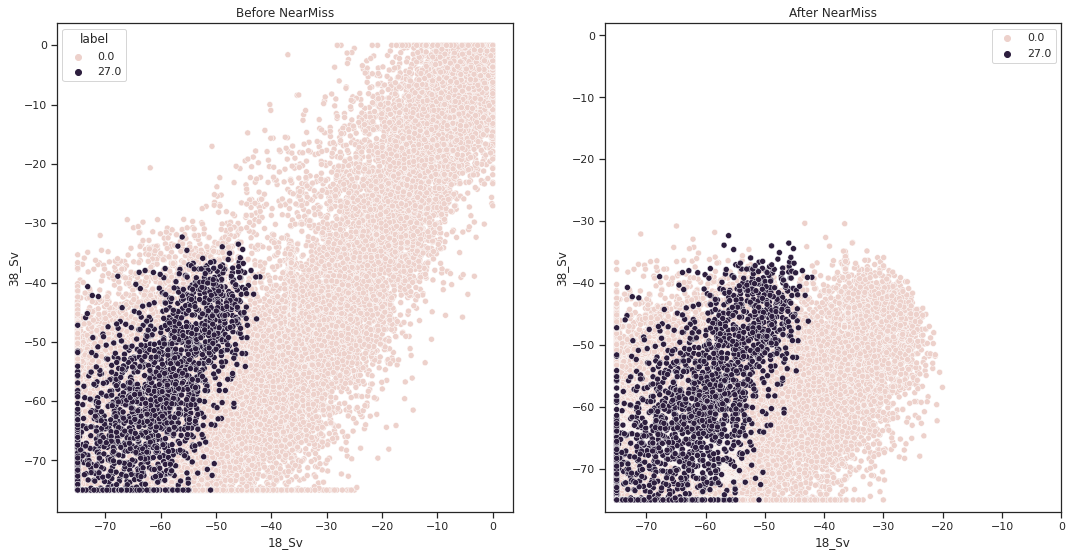

In [11]:
sns.set_theme(style="ticks")
fig, axes = plt.subplots(1, 2, sharey=False, figsize=(18,9))
sns.scatterplot(data=pd_all.sort_values(by='label'), x="18_Sv", y="38_Sv", 
                hue='label', hue_order=hue_order, ax=axes[0]).set(title='Before NearMiss')
sns.scatterplot(data=X_near, x="18_Sv", y="38_Sv", hue=Y_near.astype('float'),
                hue_order=['27.0', '0.0'], ax=axes[1]).set(title='After NearMiss')
plt.xlim(left=-77, right=0)
plt.ylim(-77, 2)
plt.show()


# Total samples by NearMiss Algorithm

In [12]:
np.unique(Y_near, return_counts=True)

(array(['0.0', '27.0'], dtype='<U4'), array([77240,  1931]))

# Final Data

In [13]:
resulting_data = pd.DataFrame.copy(pd_all)
resulting_data['sampled'] = 0
# Assigning 1 for sampled pixels
for _, i in tqdm(enumerate(nr.sample_indices_), total=len(nr.sample_indices_)):
    resulting_data.iloc[i,6] = 1 

100%|██████████| 79171/79171 [00:53<00:00, 1493.01it/s]


In [14]:
# Creating Final Array

# Resizing sampled column
output = resulting_data['sampled'].values.reshape(n_range, n_pings)
final_out=(output+resulting_data['label'].values.reshape(n_range, n_pings).astype('float'))

#Updating the annotation numbers
final_out[final_out==1], final_out[final_out==28] = 1, 2

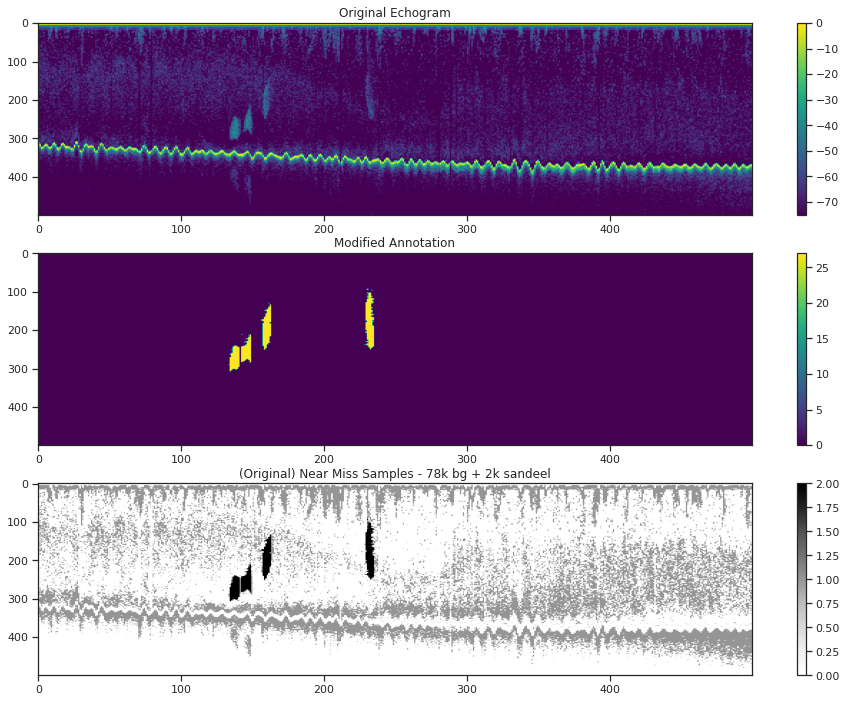

In [25]:
# Visualization of Near Miss Results
plt.figure(figsize=(16,12))
plt.subplot(3,1,3)
plt.title('(Original) Near Miss Samples - 78k bg + 2k sandeel')
plt.imshow(final_out.T, 
           cmap='Greys', aspect='auto')
plt.colorbar()
plt.subplot(3,1,1)
plt.title('Original Echogram')
plt.imshow(data_Sv.sel(frequency=38000).values.T, cmap='viridis', aspect='auto')
plt.colorbar()
plt.subplot(3,1,2)
plt.title('Modified Annotation')
plt.imshow(mod_labels.T, cmap='viridis', aspect='auto')
plt.colorbar()
plt.subplots_adjust(wspace=0)
plt.autoscale(True)
plt.show()

# Near Miss Algorithm2 - with the same sizes

In [24]:
%%time
nr2 = NearMiss(version=2) 
X_train2, y_train2 = pd_all.iloc[:,0:5], pd_all.iloc[:,5]
X_near2, Y_near2= nr2.fit_resample(X_train2, y_train2.ravel().astype('str')) 

CPU times: user 50.1 s, sys: 6.71 s, total: 56.8 s
Wall time: 56.6 s


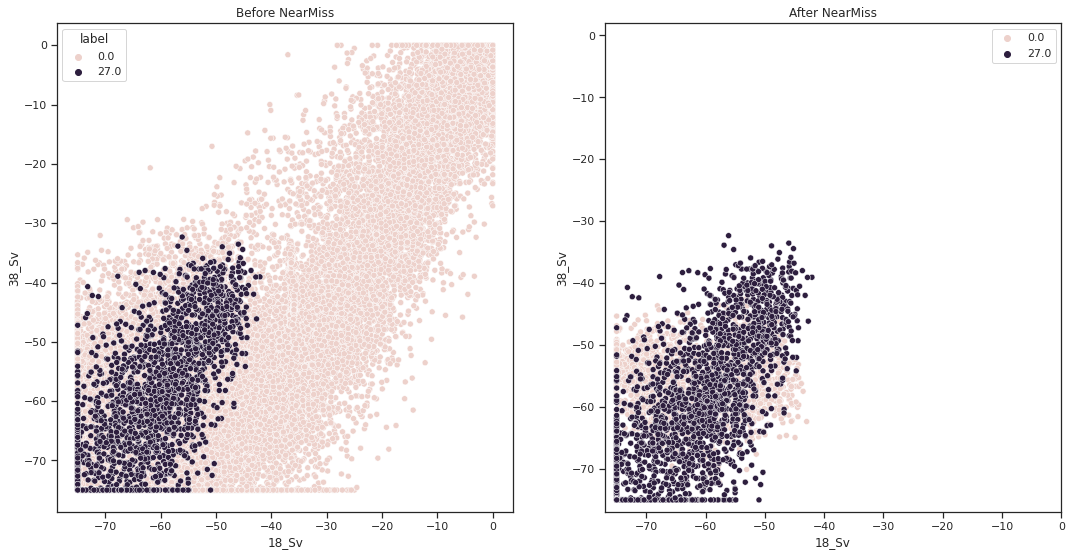

In [17]:
sns.set_theme(style="ticks")
fig, axes = plt.subplots(1, 2, sharey=False, figsize=(18,9))
sns.scatterplot(data=pd_all.sort_values(by='label'), x="18_Sv", y="38_Sv", 
                hue='label', hue_order=hue_order, ax=axes[0]).set(title='Before NearMiss')
sns.scatterplot(data=X_near2, x="18_Sv", y="38_Sv", hue=Y_near2.astype('float'),
                hue_order=['27.0', '0.0'], ax=axes[1]).set(title='After NearMiss')
plt.xlim(left=-77, right=0)
plt.ylim(-77, 2)
plt.show()

# Final Data2

In [18]:
resulting_data2 = pd.DataFrame.copy(pd_all)
resulting_data2['sampled'] = 0
# Assigning 1 for sampled pixels
for _, i in tqdm(enumerate(nr.sample_indices_), total=len(nr.sample_indices_)):
    resulting_data2.iloc[i,6] = 1 

100%|██████████| 3862/3862 [00:02<00:00, 1511.26it/s]


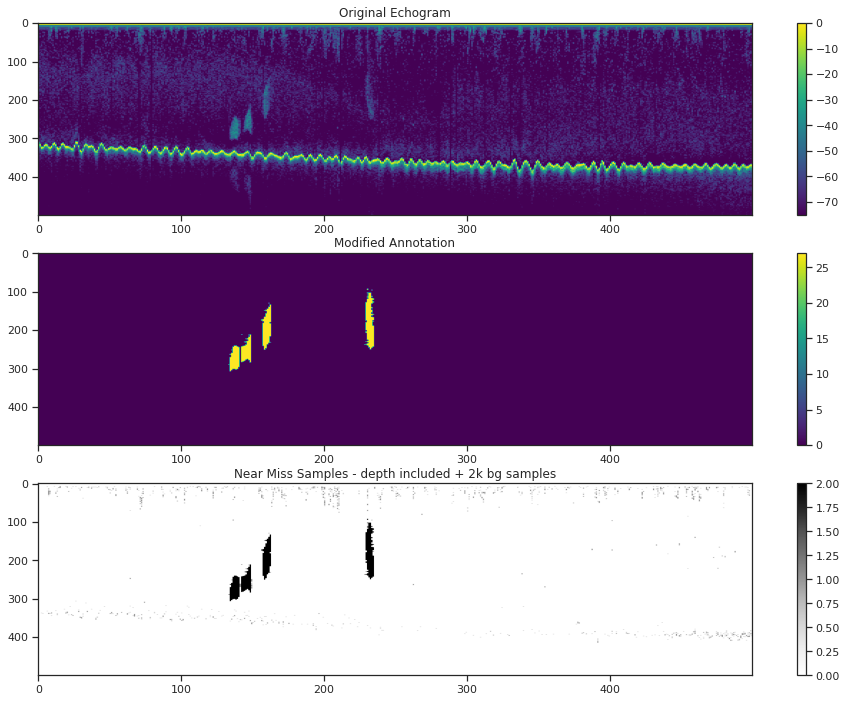

In [26]:
# Creating Final Array

# Resizing sampled column
output2 = resulting_data2['sampled'].values.reshape(n_range, n_pings)
final_out2=(output2+resulting_data2['label'].values.reshape(n_range, n_pings).astype('float'))

#Updating the annotation numbers
final_out2[final_out2==1], final_out2[final_out2==28] = 1, 2


# Visualization of Near Miss Results
plt.figure(figsize=(16,12))
plt.subplot(3,1,3)
plt.title('Near Miss Samples - depth included + 2k bg samples')
plt.imshow(final_out2.T, 
           cmap='Greys', aspect='auto')
plt.colorbar()
plt.subplot(3,1,1)
plt.title('Original Echogram')
plt.imshow(data_Sv.sel(frequency=38000).values.T, cmap='viridis', aspect='auto')
plt.colorbar()
plt.subplot(3,1,2)
plt.title('Modified Annotation')
plt.imshow(mod_labels.T, cmap='viridis', aspect='auto')
plt.colorbar()
plt.subplots_adjust(wspace=0)
plt.autoscale(True)
plt.show()

# Near Miss Algorithm - Without Depth

In [20]:
%%time
nr3 = NearMiss(version=2, sampling_strategy=0.025) 
X_train3, y_train3 = pd_all.iloc[:,0:4], pd_all.iloc[:,5]
X_near3, Y_near3 = nr3.fit_resample(X_train3, y_train3.ravel().astype('str')) 

CPU times: user 49.3 s, sys: 6.83 s, total: 56.1 s
Wall time: 55.9 s


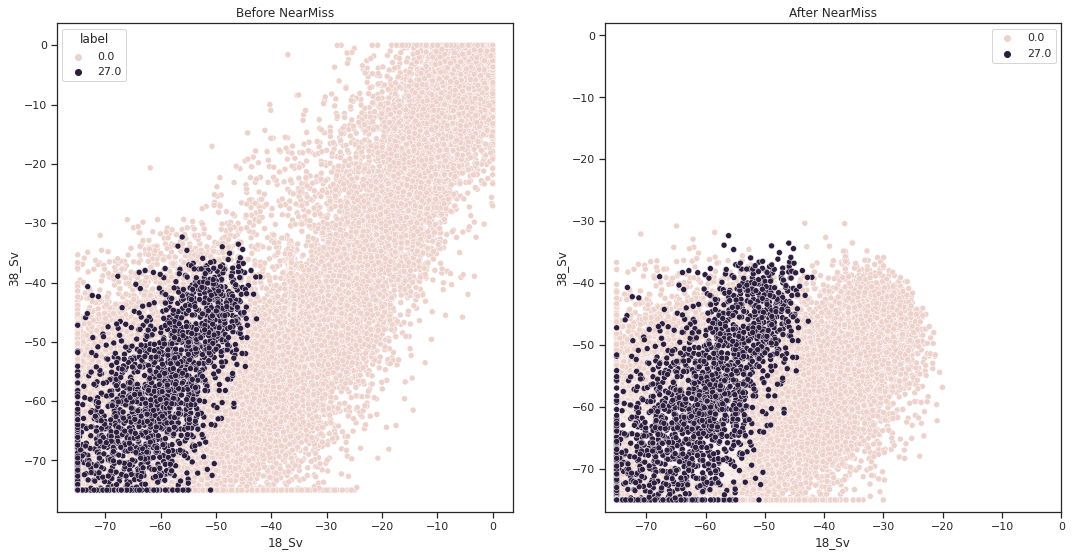

In [21]:
sns.set_theme(style="ticks")
fig, axes = plt.subplots(1, 2, sharey=False, figsize=(18,9))
sns.scatterplot(data=pd_all.sort_values(by='label'), x="18_Sv", y="38_Sv", 
                hue='label', hue_order=hue_order, ax=axes[0]).set(title='Before NearMiss')
sns.scatterplot(data=X_near3, x="18_Sv", y="38_Sv", hue=Y_near3.astype('float'),
                hue_order=['27.0', '0.0'], ax=axes[1]).set(title='After NearMiss')
plt.xlim(left=-77, right=0)
plt.ylim(-77, 2)
plt.show()

# Final Data3

In [22]:
resulting_data3 = pd.DataFrame.copy(pd_all)
resulting_data3['sampled'] = 0
# Assigning 1 for sampled pixels
for _, i in tqdm(enumerate(nr3.sample_indices_), total=len(nr3.sample_indices_)):
    resulting_data3.iloc[i,6] = 1 

100%|██████████| 79171/79171 [00:54<00:00, 1457.82it/s]


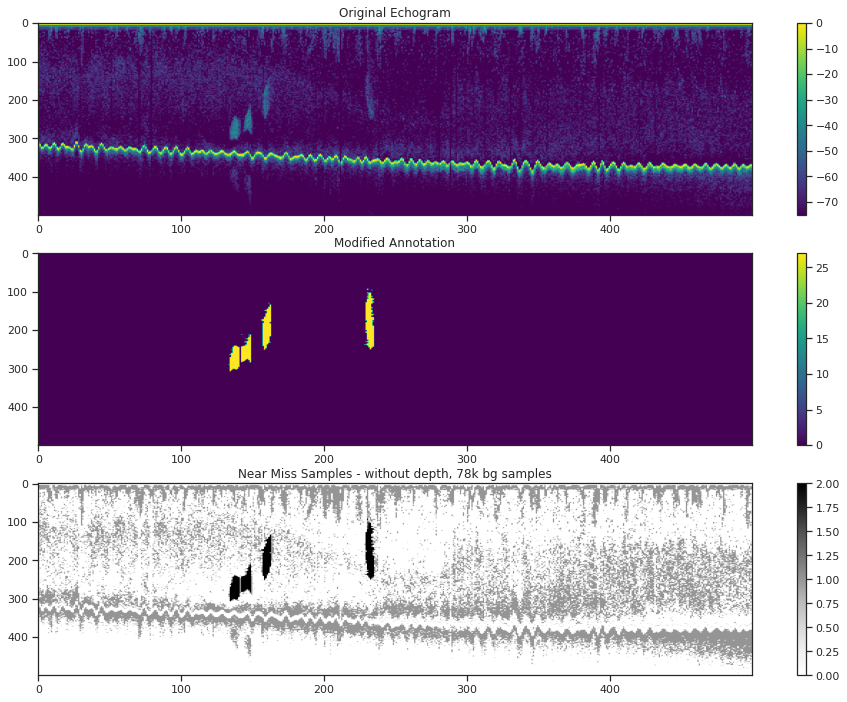

In [27]:
# Creating Final Array

# Resizing sampled column
output3 = resulting_data3['sampled'].values.reshape(n_range, n_pings)
final_out3=(output3+resulting_data3['label'].values.reshape(n_range, n_pings).astype('float'))

#Updating the annotation numbers
final_out3[final_out3==1], final_out3[final_out3==28] = 1, 2


# Visualization of Near Miss Results
plt.figure(figsize=(16,12))
plt.subplot(3,1,3)
plt.title('Near Miss Samples - without depth, 78k bg samples')
plt.imshow(final_out3.T, 
           cmap='Greys', aspect='auto')
plt.colorbar()
plt.subplot(3,1,1)
plt.title('Original Echogram')
plt.imshow(data_Sv.sel(frequency=38000).values.T, cmap='viridis', aspect='auto')
plt.colorbar()
plt.subplot(3,1,2)
plt.title('Modified Annotation')
plt.imshow(mod_labels.T, cmap='viridis', aspect='auto')
plt.colorbar()
plt.subplots_adjust(wspace=0)
plt.autoscale(True)
plt.show()